## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
from tensorflow.keras.layers import StringLookup
from tqdm import tqdm
from tensorflow.keras import layers
import pandas as pd
import math
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os

In [ ]:
dataset_path = 'drive/MyDrive/ADM/movielens/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
users_info = pd.read_csv(dataset_path + "users.dat", sep="::", names=["user_id", "sex", "age_group", "occupation", "zip_code"])

movies_info = pd.read_csv(dataset_path + "movies.dat", sep="::", names=["movie_id", "title", "genres"])

ratings_info = pd.read_csv(dataset_path + "ratings.dat", sep="::", names=["user_id", "movie_id", "rating", "unix_timestamp"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid thi

In [ ]:
users_info["occupation"] = users_info["occupation"].apply(lambda x: f"occupation_{x}")
users_info["age_group"] = users_info["age_group"].apply(lambda x: f"group_{x}")
users_info["user_id"] = users_info["user_id"].apply(lambda x: f"user_{x}")

ratings_info["rating"] = ratings_info["rating"].apply(lambda x: float(x))
ratings_info["user_id"] = ratings_info["user_id"].apply(lambda x: f"user_{x}")
ratings_info["movie_id"] = ratings_info["movie_id"].apply(lambda x: f"movie_{x}")

movies_info["movie_id"] = movies_info["movie_id"].apply(lambda x: f"movie_{x}")

In [ ]:
genres = [
    "Action",
    "Sci-Fi",
    "Thriller",
    "Adventure",
    "Crime",
    "Romance",
    "War",
    "Documentary",
    "Animation",
    "Children's",
    "Musical",
    "Drama",
    "Fantasy",
    "Mystery",
    "Western",
    "Comedy",
    "Film-Noir",
    "Horror",
]

for val in genres:
    movies_info[val] = movies_info["genres"].apply(
        lambda values: int(val in values.split("|"))
    )

In [ ]:
group_ratings = ratings_info.sort_values(by=["unix_timestamp"]).groupby("user_id")

data_ratings = pd.DataFrame(
    data={
        "ratings": list(group_ratings.rating.apply(list)),
        "user_id": list(group_ratings.groups.keys()),
        "timestamps": list(group_ratings.unix_timestamp.apply(list)),
        "movie_ids": list(group_ratings.movie_id.apply(list))
    }
)

In [ ]:
def generate_seq(values, win_size, steps):
    sequences = []
    begin = 0
    while True:
        end = begin + win_size
        seq = values[begin:end]
        if len(seq) < win_size:
            seq = values[-win_size:]
            if len(seq) == win_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        begin += steps
    return sequences

data_ratings.movie_ids = data_ratings.movie_ids.apply(
    lambda ids: generate_seq(ids, 4, 2))

data_ratings.ratings = data_ratings.ratings.apply(
    lambda ids: generate_seq(ids, 4, 2))

del data_ratings["timestamps"]

In [ ]:
movies_in_ratings_data = data_ratings[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True)
rating_in_ratings_data = data_ratings[["ratings"]].explode(
    "ratings", ignore_index=True)
transformed_ratings_data = pd.concat([movies_in_ratings_data, 
                                      rating_in_ratings_data], axis=1)
transformed_ratings_data = transformed_ratings_data.join(
    users_info.set_index("user_id"), on="user_id")

transformed_ratings_data.ratings = transformed_ratings_data.ratings.apply( lambda y: ",".join([str(c) for c in y]))
transformed_ratings_data.movie_ids = transformed_ratings_data.movie_ids.apply(lambda b: ",".join(b))

del transformed_ratings_data["zip_code"]

transformed_ratings_data.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "seq_ratings"},
    inplace=True,
)

In [ ]:
transformed_ratings_data.head()

,user_id,sequence_movie_ids,seq_ratings,sex,age_group,occupation
0,user_1,"movie_3186,movie_1721,movie_1270,movie_1022","4.0,4.0,5.0,5.0",F,group_1,occupation_10
1,user_1,"movie_1270,movie_1022,movie_2340,movie_1836","5.0,5.0,3.0,5.0",F,group_1,occupation_10
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
3,user_1,"movie_3408,movie_1207,movie_2804,movie_260","4.0,4.0,5.0,4.0",F,group_1,occupation_10
4,user_1,"movie_2804,movie_260,movie_720,movie_1193","5.0,4.0,3.0,5.0",F,group_1,occupation_10


In [ ]:
random_partition = np.random.rand(len(transformed_ratings_data.index)) <= 0.799
train_data = transformed_ratings_data[random_partition]
test_data = transformed_ratings_data[~random_partition]

test_data.to_csv(dataset_path + "test_data.csv", index=False, sep="|", header=False)
train_data.to_csv(dataset_path + "train_data.csv", index=False, sep="|", header=False)

In [ ]:
csv_HEADER = list(transformed_ratings_data.columns)

CATEGORICAL_FEAT_WITH_VOCAB = {
    "occupation": list(users_info.occupation.unique()),
    "sex": list(users_info.sex.unique()),
    "user_id": list(users_info.user_id.unique()),
    "age_group": list(users_info.age_group.unique()),
    "movie_id": list(movies_info.movie_id.unique())
}

movie_feat = ["genres"]
user_feat = ["sex", "age_group", "occupation"]

In [ ]:
def getData_from_csv(csv_file_path, shuffle=False, batches=128):
    def function(feat):
        movie_ids_str = feat["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_str, ",").to_tensor()

        feat["sequence_movie_ids"] = sequence_movie_ids[:, :-1]
        feat["target_movieID"] = sequence_movie_ids[:, -1]

        ratings_str = feat["seq_ratings"]
        seq_ratings = tf.strings.to_number(
            tf.strings.split(ratings_str, ","), tf.dtypes.float32
        ).to_tensor()

        trg = seq_ratings[:, -1]
        feat["seq_ratings"] = seq_ratings[:, :-1]

        return feat, trg

    df = tf.data.experimental.make_csv_dataset(csv_file_path, batch_size=batches, column_names=csv_HEADER, num_epochs=1, header=False, field_delim="|",shuffle=shuffle,).map(function)

    return df

In [ ]:
def generate_model_inputs():
    return {
        "seq_ratings": layers.Input(
            name="seq_ratings", shape=(3,), dtype=tf.float32
        ),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "target_movieID": layers.Input(
            name="target_movieID", shape=(1,), dtype=tf.string
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(3,), 
            dtype=tf.string
        ),
    }

In [ ]:
def encode_ip_feat(ip, add_user_id=True, add_user_feat=True, add_movie_feat=True):

    other_feats = []
    encoded_feat_other = []
    transf_feat_encoded = []

    if add_user_feat:
        other_feats.extend(user_feat)
    if add_user_id:
        other_feats.append("user_id")

    for feat in other_feats:
        vocab = CATEGORICAL_FEAT_WITH_VOCAB[feat]
        idx = StringLookup(vocab=vocab, mask_token=None, num_oov_indices=0)(ip[feat])
        embedding_dims = int(math.sqrt(len(vocab)))
        embedding_encoder = layers.Embedding(input_dim=len(vocab),output_dim=embedding_dims,name=f"{feat}_embedding",)
        encoded_feat_other.append(embedding_encoder(idx))

    if len(encoded_feat_other) > 1:
        encoded_feat_other = layers.concatenate(encoded_feat_other)
    elif len(encoded_feat_other) == 1:
        encoded_feat_other = encoded_feat_other[0]
    else:
        encoded_feat_other = None

    movie_vocab = CATEGORICAL_FEAT_WITH_VOCAB["movie_id"]
    movie_embed_dims = int(math.sqrt(len(movie_vocab)))
    
    movie_index_search = StringLookup(vocabulary=movie_vocab,mask_token=None,num_oov_indices=0,name="movie_index_search",)
    movie_embed_encoder = layers.Embedding(input_dim=len(movie_vocab),output_dim=movie_embed_dims,name=f"movie_embedding",)
    genre_vec = movies_info[genres].to_numpy()
    movie_genres_search = layers.Embedding(input_dim=genre_vec.shape[0],output_dim=genre_vec.shape[1],embeddings_initializer=tf.keras.initializers.Constant(genre_vec),trainable=False,name="genres_vector",)
    movie_embed_process = layers.Dense(units=movie_embed_dims,activation="relu",name="process_movie_embedding_with_genres",)

    def movie_encode(movie_id):
        movie_idx = movie_index_search(movie_id)
        movie_embed = movie_embed_encoder(movie_idx)
        movie_encoded = movie_embed
        if add_movie_feat:
          movie_genres_vector = movie_genres_search(movie_idx)
          movie_encoded = movie_embed_process(layers.concatenate([movie_embed, movie_genres_vector]))
        return movie_encoded

    target_movieID = ip["target_movieID"]
    target_movie_encoded = movie_encode(target_movieID)

    sequence_moviesIDs = ip["sequence_movie_ids"]
    seq_movies_encoded = movie_encode(sequence_moviesIDs)
    pos_embed_encoder = layers.Embedding(input_dim=4,output_dim=movie_embed_dims,name="position_embedding",)
    pos = tf.range(start=0, limit=3, delta=1)
    pos_encoded = pos_embed_encoder(pos)
    seq_ratings = tf.expand_dims(ip["seq_ratings"], -1)
    seq_movies_encoded_with_pos_and_rating = layers.Multiply()([(seq_movies_encoded + pos_encoded), seq_ratings])

    for movie_encoded in tf.unstack(seq_movies_encoded_with_pos_and_rating, axis=1):
      transf_feat_encoded.append(tf.expand_dims(movie_encoded, 1))
      
    transf_feat_encoded.append(target_movie_encoded)
    transf_feat_encoded = layers.concatenate(transf_feat_encoded, axis=1)

    return transf_feat_encoded, encoded_feat_other

In [ ]:
add_movie_feat = add_user_feat = add_user_id = False

hidden_neurons = [256, 128]
num_heads = 3


def generate_model():
    ip = generate_model_inputs()
    transf_feat, other_feat = encode_ip_feat(ip, add_user_id, add_user_feat, add_movie_feat)

    attention_model_op = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transf_feat.shape[2], dropout=0.1)(transf_feat, transf_feat)

    attention_model_op = layers.Dropout(0.1)(attention_model_op)
    y1 = layers.Add()([transf_feat, attention_model_op])
    y1 = layers.LayerNormalization()(y1)
    y2 = layers.LeakyReLU()(y1)
    y2 = layers.Dense(units=y2.shape[-1])(y2)
    y2 = layers.Dropout(0.1)(y2)
    transf_feat = layers.Add()([y1, y2])
    transf_feat = layers.LayerNormalization()(transf_feat)
    feat = layers.Flatten()(transf_feat)

    if other_feat is not None:
        feat = layers.concatenate([feat, layers.Reshape([other_feat.shape[-1]])(other_feat)]

    for unit in hidden_neurons:
        feat = layers.Dense(unit)(feat)
        feat = layers.BatchNormalization()(feat)
        feat = layers.LeakyReLU()(feat)
        feat = layers.Dropout(0.1)(feat)

    op = layers.Dense(units=1)(feat)
    model = keras.Model(inputs=ip, outputs=op)
    return model


model = generate_model()

In [ ]:
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01),loss=keras.losses.MeanSquaredError(),metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],)

train_df = getData_from_csv(dataset_path + "train_data.csv", shuffle=True, batches=265)


In [ ]:
hist = model.fit(train_df, epochs=10)

Epoch 1/10
1601/1601 [==============================] - 30s 18ms/step - loss: 1.2859 - mean_absolute_error: 0.8965 - root_mean_squared_error: 1.1340
Epoch 2/10
1601/1601 [==============================] - 28s 18ms/step - loss: 1.0208 - mean_absolute_error: 0.8055 - root_mean_squared_error: 1.0104
Epoch 3/10
1601/1601 [==============================] - 28s 18ms/step - loss: 0.9628 - mean_absolute_error: 0.7822 - root_mean_squared_error: 0.9812
Epoch 4/10
1601/1601 [==============================] - 28s 18ms/step - loss: 0.9326 - mean_absolute_error: 0.7695 - root_mean_squared_error: 0.9657
Epoch 5/10
1601/1601 [==============================] - 28s 18ms/step - loss: 0.9112 - mean_absolute_error: 0.7597 - root_mean_squared_error: 0.9546
Epoch 6/10
1601/1601 [==============================] - 28s 18ms/step - loss: 0.8949 - mean_absolute_error: 0.7527 - root_mean_squared_error: 0.9460
Epoch 7/10
1601/1601 [==============================] - 28s 18ms/step - loss: 0.8847 - mean_absolute_error

In [ ]:
model.save(dataset_path + 'BST.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Loading Saved Model

In [ ]:
model = tf.keras.models.load_model(dataset_path + 'BST.h5')

### Testing

In [ ]:
test_df = getData_from_csv(dataset_path + "test_data.csv", batches=265)

_, MAE, RMSE = model.evaluate(test_df, verbose=0)
print(f"Test MAE: {round(MAE, 3)}")
print(f"Test RMSE : {round(RMSE, 3)}")

Test MAE: 0.762
Test RMSE : 0.95


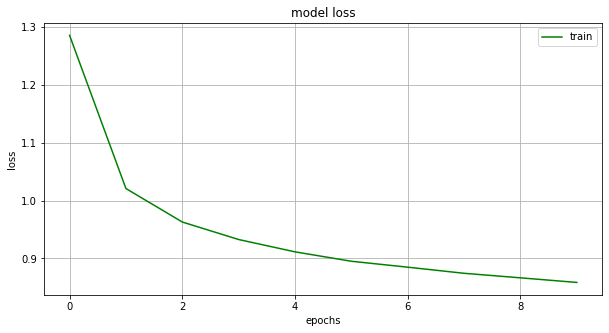

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()